In [8]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import savefig
import time


%matplotlib inline

In [9]:
#to generate the date list for data download
date1 = '2017-09-23'   
date2 = '2018-09-22'
start = datetime.datetime.strptime(date1, '%Y-%m-%d')
end = datetime.datetime.strptime(date2, '%Y-%m-%d')
step = datetime.timedelta(days = 7)

week_nums_datetime_format = []
while start <= end:
    week_nums_datetime_format.append(start.date())
    start += step
    
week_nums_string = [str(week_num) for week_num in week_nums_datetime_format]

week_nums = [int(week_num[2:4] + week_num[5:7] + week_num[8:]) for week_num in week_nums_string]
print (week_nums)

[170923, 170930, 171007, 171014, 171021, 171028, 171104, 171111, 171118, 171125, 171202, 171209, 171216, 171223, 171230, 180106, 180113, 180120, 180127, 180203, 180210, 180217, 180224, 180303, 180310, 180317, 180324, 180331, 180407, 180414, 180421, 180428, 180505, 180512, 180519, 180526, 180602, 180609, 180616, 180623, 180630, 180707, 180714, 180721, 180728, 180804, 180811, 180818, 180825, 180901, 180908, 180915, 180922]


In [10]:
# Source: http://web.mta.info/developers/turnstile.html
#combine the data through the entire year to find a maximum 
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        print (week_num)
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
turnstiles_df = get_data(week_nums)


170923
170930
171007
171014
171021
171028
171104
171111
171118
171125
171202
171209
171216
171223
171230
180106
180113
180120
180127
180203
180210
180217
180224
180303
180310
180317
180324
180331
180407
180414
180421
180428
180505
180512
180519
180526
180602
180609
180616
180623
180630
180707
180714
180721
180728
180804
180811
180818
180825
180901
180908
180915
180922


In [11]:
df = turnstiles_df.copy()

In [12]:
#generate a datetime object
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, format="%m/%d/%Y %H:%M:%S")

In [13]:
# to clean up the column formate
df.rename(columns={'ENTRIES': 'cumulative_entries', 'EXITS                                                               ': 'cumulative_exits'}, inplace=True)
# or use strip to clean the space
#turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns

In [14]:
#first step to sort the values so the data is more organized and clear to process, expecially we will use diff to get
#difference between time points to get net entries or exits
df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [15]:
df.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,cumulative_entries,cumulative_exits,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,00:00:00,REGULAR,6328434,2141537,2017-09-16 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,04:00:00,REGULAR,6328480,2141541,2017-09-16 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,08:00:00,REGULAR,6328503,2141580,2017-09-16 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,12:00:00,REGULAR,6328598,2141674,2017-09-16 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,16:00:00,REGULAR,6328838,2141731,2017-09-16 16:00:00
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,20:00:00,REGULAR,6329154,2141779,2017-09-16 20:00:00
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2017,00:00:00,REGULAR,6329336,2141799,2017-09-17 00:00:00
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2017,04:00:00,REGULAR,6329364,2141801,2017-09-17 04:00:00
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2017,08:00:00,REGULAR,6329382,2141821,2017-09-17 08:00:00
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2017,12:00:00,REGULAR,6329451,2141887,2017-09-17 12:00:00


In [16]:
# one turnstile--identified by C/A, UNIT, SCP at one specific station at one specific time should be unique, check
# to make sure
(df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .cumulative_entries.count()
 .reset_index()
 .sort_values("cumulative_entries", ascending=False)).head(20)

,C/A,UNIT,SCP,STATION,DATE_TIME,cumulative_entries
1144163,C014,R246,00-00-00,PROSPECT AV,2017-10-29 16:00:00,2
471238,A050,R088,00-02-00,CORTLANDT ST,2017-12-28 20:00:00,2
576922,A061,R142,00-00-00,DELANCEY/ESSEX,2017-10-27 09:00:00,2
1144160,C014,R246,00-00-00,PROSPECT AV,2017-10-29 04:00:00,2
1144161,C014,R246,00-00-00,PROSPECT AV,2017-10-29 08:00:00,2
1144162,C014,R246,00-00-00,PROSPECT AV,2017-10-29 12:00:00,2
9419570,R515,R095,00-00-01,ASTORIA DITMARS,2018-08-07 16:00:00,2
1144164,C014,R246,00-00-00,PROSPECT AV,2017-10-29 20:00:00,2
1144165,C014,R246,00-00-00,PROSPECT AV,2017-10-30 00:00:00,2
10166515,R627,R063,00-03-02,SUTTER AV-RUTLD,2018-02-04 07:00:00,2


In [17]:
df['DATE_TIME'].describe()

count                10476883
unique                 686597
top       2018-03-03 23:00:00
freq                     2444
first     2017-09-16 00:00:00
last      2018-09-21 23:59:34
Name: DATE_TIME, dtype: object

In [18]:
from datetime import datetime

In [19]:
#take a look at at the specific time and station to see why there is 2 values
mask = ((df['C/A'] == 'C014') &
        (df['UNIT'] == 'R246') &
        (df['SCP'] == '00-00-00')&
        (df['STATION'] == 'PROSPECT AV')&
        (df['DATE_TIME'] == datetime(*(2017, 10, 29, 16, 0, 0))))

df[mask]


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,cumulative_entries,cumulative_exits,DATE_TIME
21412,C014,R246,00-00-00,PROSPECT AV,R,BMT,10/29/2017,16:00:00,REGULAR,12366621,2707166,2017-10-29 16:00:00
21413,C014,R246,00-00-00,PROSPECT AV,R,BMT,10/29/2017,16:00:00,RECOVR AUD,8239903,3204411,2017-10-29 16:00:00


In [20]:
# there is a regular and a recor aud values, drop the recovr aud values. It is good practice to check whether there is 
# unexpected different values assign to one specific indentifier
df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [21]:
# shift the data down one row so can get the previous time point number
df[['pre_CA','preUNIT','pre_SCP','pre_date','pre_entries','pre_exits']] = (df[['C/A','UNIT','SCP','DATE_TIME','cumulative_entries','cumulative_exits']].transform(lambda grp: grp.shift(1)))

In [22]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,cumulative_entries,cumulative_exits,DATE_TIME,pre_CA,preUNIT,pre_SCP,pre_date,pre_entries,pre_exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,00:00:00,REGULAR,6328434,2141537,2017-09-16 00:00:00,NaN,NaN,NaN,NaT,NaN,NaN
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,04:00:00,REGULAR,6328480,2141541,2017-09-16 04:00:00,A002,R051,02-00-00,2017-09-16 00:00:00,6328434.0,2141537.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,08:00:00,REGULAR,6328503,2141580,2017-09-16 08:00:00,A002,R051,02-00-00,2017-09-16 04:00:00,6328480.0,2141541.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,12:00:00,REGULAR,6328598,2141674,2017-09-16 12:00:00,A002,R051,02-00-00,2017-09-16 08:00:00,6328503.0,2141580.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,16:00:00,REGULAR,6328838,2141731,2017-09-16 16:00:00,A002,R051,02-00-00,2017-09-16 12:00:00,6328598.0,2141674.0


In [23]:
#create the turnstile_id for the current turnstile

df['Turnstile_id'] = df['C/A'] + ' ' + df['UNIT'] + df['SCP']

In [24]:
#create the turnstile_id for the previous turnstile

df['pre_Turnstile_id'] = df['pre_CA'] + ' ' + df['preUNIT'] + df['pre_SCP']

In [25]:
df.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,cumulative_entries,cumulative_exits,DATE_TIME,pre_CA,preUNIT,pre_SCP,pre_date,pre_entries,pre_exits,Turnstile_id,pre_Turnstile_id
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,00:00:00,REGULAR,6328434,2141537,2017-09-16 00:00:00,NaN,NaN,NaN,NaT,NaN,NaN,A002 R05102-00-00,NaN
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,04:00:00,REGULAR,6328480,2141541,2017-09-16 04:00:00,A002,R051,02-00-00,2017-09-16 00:00:00,6328434.0,2141537.0,A002 R05102-00-00,A002 R05102-00-00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,08:00:00,REGULAR,6328503,2141580,2017-09-16 08:00:00,A002,R051,02-00-00,2017-09-16 04:00:00,6328480.0,2141541.0,A002 R05102-00-00,A002 R05102-00-00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,12:00:00,REGULAR,6328598,2141674,2017-09-16 12:00:00,A002,R051,02-00-00,2017-09-16 08:00:00,6328503.0,2141580.0,A002 R05102-00-00,A002 R05102-00-00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,16:00:00,REGULAR,6328838,2141731,2017-09-16 16:00:00,A002,R051,02-00-00,2017-09-16 12:00:00,6328598.0,2141674.0,A002 R05102-00-00,A002 R05102-00-00


In [26]:
#filter the data to have only the turstile_id mathching with the previous time piont, otherwise it will substract between two
#turstile, and the number is meaningless

df1 = df[df['Turnstile_id'] == df['pre_Turnstile_id']].copy()

In [27]:
df1.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,cumulative_entries,cumulative_exits,DATE_TIME,pre_CA,preUNIT,pre_SCP,pre_date,pre_entries,pre_exits,Turnstile_id,pre_Turnstile_id
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,04:00:00,REGULAR,6328480,2141541,2017-09-16 04:00:00,A002,R051,02-00-00,2017-09-16 00:00:00,6328434.0,2141537.0,A002 R05102-00-00,A002 R05102-00-00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,08:00:00,REGULAR,6328503,2141580,2017-09-16 08:00:00,A002,R051,02-00-00,2017-09-16 04:00:00,6328480.0,2141541.0,A002 R05102-00-00,A002 R05102-00-00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,12:00:00,REGULAR,6328598,2141674,2017-09-16 12:00:00,A002,R051,02-00-00,2017-09-16 08:00:00,6328503.0,2141580.0,A002 R05102-00-00,A002 R05102-00-00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,16:00:00,REGULAR,6328838,2141731,2017-09-16 16:00:00,A002,R051,02-00-00,2017-09-16 12:00:00,6328598.0,2141674.0,A002 R05102-00-00,A002 R05102-00-00
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,20:00:00,REGULAR,6329154,2141779,2017-09-16 20:00:00,A002,R051,02-00-00,2017-09-16 16:00:00,6328838.0,2141731.0,A002 R05102-00-00,A002 R05102-00-00


In [28]:
#calculate net_entries and net_exits based on the current and previous data point
#create a column net_traffic for the total traffic
#also create a column records the time span, since there is different way how time was recorded, the time span might be 
#different

df1['net_entries'] = df1['cumulative_entries'] - df1['pre_entries']
df1['net_exits'] = df1['cumulative_exits'] - df1['pre_exits']
df1['net_traffic'] = df1['net_entries'] + df1['net_exits']
df1['time_span_min'] = (df1['DATE_TIME'] - df1['pre_date']).dt.seconds/60
df1['time_span_hour'] =  (df1['DATE_TIME'] - df1['pre_date']).dt.seconds/60/60

In [29]:
df1.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,cumulative_entries,...,pre_date,pre_entries,pre_exits,Turnstile_id,pre_Turnstile_id,net_entries,net_exits,net_traffic,time_span_min,time_span_hour
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,04:00:00,REGULAR,6328480,...,2017-09-16 00:00:00,6328434.0,2141537.0,A002 R05102-00-00,A002 R05102-00-00,46.0,4.0,50.0,240.0,4.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,08:00:00,REGULAR,6328503,...,2017-09-16 04:00:00,6328480.0,2141541.0,A002 R05102-00-00,A002 R05102-00-00,23.0,39.0,62.0,240.0,4.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,12:00:00,REGULAR,6328598,...,2017-09-16 08:00:00,6328503.0,2141580.0,A002 R05102-00-00,A002 R05102-00-00,95.0,94.0,189.0,240.0,4.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,16:00:00,REGULAR,6328838,...,2017-09-16 12:00:00,6328598.0,2141674.0,A002 R05102-00-00,A002 R05102-00-00,240.0,57.0,297.0,240.0,4.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,20:00:00,REGULAR,6329154,...,2017-09-16 16:00:00,6328838.0,2141731.0,A002 R05102-00-00,A002 R05102-00-00,316.0,48.0,364.0,240.0,4.0


In [30]:
#check the different time span
(df1.groupby('time_span_hour').count().reset_index()).head(20)

,time_span_hour,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,...,pre_SCP,pre_date,pre_entries,pre_exits,Turnstile_id,pre_Turnstile_id,net_entries,net_exits,net_traffic,time_span_min
0,0.000000,245,245,245,245,245,245,245,245,245,...,245,245,245,245,245,245,245,245,245,245
1,0.000278,38,38,38,38,38,38,38,38,38,...,38,38,38,38,38,38,38,38,38,38
2,0.000556,57,57,57,57,57,57,57,57,57,...,57,57,57,57,57,57,57,57,57,57
3,0.000833,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
4,0.001111,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
5,0.001389,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
6,0.001667,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
7,0.001944,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
8,0.002222,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
9,0.002500,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24


In [37]:
#there is lots of time span is very short, filter those out, I specfically take a 4-hour time slot
df2 = df1.copy()
df2 = df2[df2['time_span_hour']  == 4]

In [38]:
#to look at what kind of time span and how frequent they are
(df2.groupby('time_span_hour').count().reset_index().sort_values("time_span_min", ascending=False)).head(30)

,time_span_hour,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,...,pre_SCP,pre_date,pre_entries,pre_exits,Turnstile_id,pre_Turnstile_id,net_entries,net_exits,net_traffic,time_span_min
0,4.0,9626769,9626769,9626769,9626769,9626769,9626769,9626769,9626769,9626769,...,9626769,9626769,9626769,9626769,9626769,9626769,9626769,9626769,9626769,9626769


In [40]:
#clean up the n/a data
df2.dropna(how = 'any').copy().head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,cumulative_entries,...,pre_date,pre_entries,pre_exits,Turnstile_id,pre_Turnstile_id,net_entries,net_exits,net_traffic,time_span_min,time_span_hour
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,04:00:00,REGULAR,6328480,...,2017-09-16 00:00:00,6328434.0,2141537.0,A002 R05102-00-00,A002 R05102-00-00,46.0,4.0,50.0,240.0,4.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,08:00:00,REGULAR,6328503,...,2017-09-16 04:00:00,6328480.0,2141541.0,A002 R05102-00-00,A002 R05102-00-00,23.0,39.0,62.0,240.0,4.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,12:00:00,REGULAR,6328598,...,2017-09-16 08:00:00,6328503.0,2141580.0,A002 R05102-00-00,A002 R05102-00-00,95.0,94.0,189.0,240.0,4.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,16:00:00,REGULAR,6328838,...,2017-09-16 12:00:00,6328598.0,2141674.0,A002 R05102-00-00,A002 R05102-00-00,240.0,57.0,297.0,240.0,4.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,20:00:00,REGULAR,6329154,...,2017-09-16 16:00:00,6328838.0,2141731.0,A002 R05102-00-00,A002 R05102-00-00,316.0,48.0,364.0,240.0,4.0


In [41]:
#take a look at the range of net_entries data
df2.net_entries.describe()

count    9.626769e+06
mean     1.270700e+03
std      2.465189e+06
min     -2.142302e+09
25%      1.100000e+01
50%      7.600000e+01
75%      2.410000e+02
max      2.142302e+09
Name: net_entries, dtype: float64

In [42]:
#there is some abnormally low and high number. For the negative number, it might due to turstile reset, filter those out
df3 = df2[(df2['net_entries']>0) & (df2['net_exits']>0)].copy()

In [43]:
#take a look again 
df3.net_entries.describe()

count    7.929183e+06
mean     3.481443e+03
std      2.153976e+06
min      1.000000e+00
25%      3.400000e+01
50%      1.180000e+02
75%      2.890000e+02
max      2.142302e+09
Name: net_entries, dtype: float64

In [44]:
df3.net_exits.describe()

count    7.929183e+06
mean     4.259109e+03
std      2.592156e+06
min      1.000000e+00
25%      2.600000e+01
50%      7.800000e+01
75%      1.970000e+02
max      2.145033e+09
Name: net_exits, dtype: float64

In [51]:
#there is some really high number in both columns, which is impossbile. This is only one turstile during 4 hours, 
#thinking that even one entries per second, it will only be 4* 3600 per turstile, take a look at the abnormal number
df_high_entries = df3[df3.net_entries > 50000]
df_high_entries[['STATION','DATE_TIME','cumulative_entries','Turnstile_id','pre_date','pre_entries','pre_Turnstile_id','net_entries','DESC']].head(20)



,STATION,DATE_TIME,cumulative_entries,Turnstile_id,pre_date,pre_entries,pre_Turnstile_id,net_entries,DESC
12755,FULTON ST,2018-02-15 10:00:00,101515533,A082 R02805-06-01,2018-02-15 06:00:00,34435550.0,A082 R02805-06-01,6.707998e+07,REGULAR
14947,CORTELYOU RD,2018-09-15 00:00:00,15832652,B018 R18400-00-00,2018-09-14 20:00:00,458752.0,B018 R18400-00-00,1.537390e+07,REGULAR
15402,AVENUE H,2018-05-23 16:00:00,616630,B020 R26300-03-01,2018-05-23 12:00:00,92862.0,B020 R26300-03-01,5.237680e+05,REGULAR
22769,53 ST,2018-08-14 12:00:00,50386730,C020 R23300-03-02,2018-08-14 08:00:00,254800.0,C020 R23300-03-02,5.013193e+07,REGULAR
23018,BAY RIDGE AV,2017-10-10 20:00:00,5184970,C023 R21300-00-00,2017-10-10 16:00:00,2684419.0,C023 R21300-00-00,2.500551e+06,RECOVR AUD
23088,BAY RIDGE AV,2017-10-11 16:00:00,7595915,C023 R21300-00-01,2017-10-11 12:00:00,6656918.0,C023 R21300-00-01,9.389970e+05,REGULAR
28633,CONEY IS-STILLW,2018-03-31 17:00:00,1900568,G009 R15102-00-03,2018-03-31 13:00:00,18845.0,G009 R15102-00-03,1.881723e+06,REGULAR
41724,190 ST,2018-06-10 20:00:00,1442830408,N006A R28000-00-00,2018-06-10 16:00:00,11142660.0,N006A R28000-00-00,1.431688e+09,REGULAR
48842,42 ST-PORT AUTH,2017-10-17 12:00:00,262144,N062 R01101-05-01,2017-10-10 08:00:00,0.0,N062 R01101-05-01,2.621440e+05,REGULAR
50099,42 ST-PORT AUTH,2018-01-05 13:00:00,68254430,N062A R01000-05-00,2018-01-05 09:00:00,19470603.0,N062A R01000-05-00,4.878383e+07,REGULAR


In [53]:
df3.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,cumulative_entries,...,pre_date,pre_entries,pre_exits,Turnstile_id,pre_Turnstile_id,net_entries,net_exits,net_traffic,time_span_min,time_span_hour
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,04:00:00,REGULAR,6328480,...,2017-09-16 00:00:00,6328434.0,2141537.0,A002 R05102-00-00,A002 R05102-00-00,46.0,4.0,50.0,240.0,4.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,08:00:00,REGULAR,6328503,...,2017-09-16 04:00:00,6328480.0,2141541.0,A002 R05102-00-00,A002 R05102-00-00,23.0,39.0,62.0,240.0,4.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,12:00:00,REGULAR,6328598,...,2017-09-16 08:00:00,6328503.0,2141580.0,A002 R05102-00-00,A002 R05102-00-00,95.0,94.0,189.0,240.0,4.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,16:00:00,REGULAR,6328838,...,2017-09-16 12:00:00,6328598.0,2141674.0,A002 R05102-00-00,A002 R05102-00-00,240.0,57.0,297.0,240.0,4.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,20:00:00,REGULAR,6329154,...,2017-09-16 16:00:00,6328838.0,2141731.0,A002 R05102-00-00,A002 R05102-00-00,316.0,48.0,364.0,240.0,4.0
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2017,00:00:00,REGULAR,6329336,...,2017-09-16 20:00:00,6329154.0,2141779.0,A002 R05102-00-00,A002 R05102-00-00,182.0,20.0,202.0,240.0,4.0
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2017,04:00:00,REGULAR,6329364,...,2017-09-17 00:00:00,6329336.0,2141799.0,A002 R05102-00-00,A002 R05102-00-00,28.0,2.0,30.0,240.0,4.0
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2017,08:00:00,REGULAR,6329382,...,2017-09-17 04:00:00,6329364.0,2141801.0,A002 R05102-00-00,A002 R05102-00-00,18.0,20.0,38.0,240.0,4.0
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2017,12:00:00,REGULAR,6329451,...,2017-09-17 08:00:00,6329382.0,2141821.0,A002 R05102-00-00,A002 R05102-00-00,69.0,66.0,135.0,240.0,4.0
10,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2017,16:00:00,REGULAR,6329655,...,2017-09-17 12:00:00,6329451.0,2141887.0,A002 R05102-00-00,A002 R05102-00-00,204.0,54.0,258.0,240.0,4.0


In [56]:
#still don't know what happened to those really big numbers, but they are simply impossible, filter those out
#I chose 30,000 to be the upper limit for each turstile during 4 hour time frame, assumming people passing through that 
#turnstile non_stop
df_filter_exits_entries = df3[(df3['net_entries']<30000) &(df3['net_exits']<30000)]

In [57]:
df_filter_exits_entries.net_entries.describe()
df_filter_exits_entries.net_entries.describe()

count    7.929123e+06
mean     2.116906e+02
std      2.650638e+02
min      1.000000e+00
25%      3.400000e+01
50%      1.180000e+02
75%      2.890000e+02
max      1.129400e+04
Name: net_entries, dtype: float64

In [58]:
#after filter data looks more resonable
df_filter_exits_entries.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,cumulative_entries,...,pre_date,pre_entries,pre_exits,Turnstile_id,pre_Turnstile_id,net_entries,net_exits,net_traffic,time_span_min,time_span_hour
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,04:00:00,REGULAR,6328480,...,2017-09-16 00:00:00,6328434.0,2141537.0,A002 R05102-00-00,A002 R05102-00-00,46.0,4.0,50.0,240.0,4.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,08:00:00,REGULAR,6328503,...,2017-09-16 04:00:00,6328480.0,2141541.0,A002 R05102-00-00,A002 R05102-00-00,23.0,39.0,62.0,240.0,4.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,12:00:00,REGULAR,6328598,...,2017-09-16 08:00:00,6328503.0,2141580.0,A002 R05102-00-00,A002 R05102-00-00,95.0,94.0,189.0,240.0,4.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,16:00:00,REGULAR,6328838,...,2017-09-16 12:00:00,6328598.0,2141674.0,A002 R05102-00-00,A002 R05102-00-00,240.0,57.0,297.0,240.0,4.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/16/2017,20:00:00,REGULAR,6329154,...,2017-09-16 16:00:00,6328838.0,2141731.0,A002 R05102-00-00,A002 R05102-00-00,316.0,48.0,364.0,240.0,4.0
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2017,00:00:00,REGULAR,6329336,...,2017-09-16 20:00:00,6329154.0,2141779.0,A002 R05102-00-00,A002 R05102-00-00,182.0,20.0,202.0,240.0,4.0
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2017,04:00:00,REGULAR,6329364,...,2017-09-17 00:00:00,6329336.0,2141799.0,A002 R05102-00-00,A002 R05102-00-00,28.0,2.0,30.0,240.0,4.0
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2017,08:00:00,REGULAR,6329382,...,2017-09-17 04:00:00,6329364.0,2141801.0,A002 R05102-00-00,A002 R05102-00-00,18.0,20.0,38.0,240.0,4.0
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2017,12:00:00,REGULAR,6329451,...,2017-09-17 08:00:00,6329382.0,2141821.0,A002 R05102-00-00,A002 R05102-00-00,69.0,66.0,135.0,240.0,4.0
10,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2017,16:00:00,REGULAR,6329655,...,2017-09-17 12:00:00,6329451.0,2141887.0,A002 R05102-00-00,A002 R05102-00-00,204.0,54.0,258.0,240.0,4.0


In [63]:
#another look at the net_traffic
df_filter_exits_entries.net_traffic.describe()

count    7.929123e+06
mean     3.715133e+02
std      3.946991e+02
min      2.000000e+00
25%      8.600000e+01
50%      2.440000e+02
75%      5.240000e+02
max      1.833300e+04
Name: net_traffic, dtype: float64

In [68]:
#get the total counts by stations during the 4 hour time frame
df6 = df_filter_exits_entries.groupby(['STATION','DATE_TIME']).sum().reset_index().copy()


In [69]:
df6.head(20)

,STATION,DATE_TIME,cumulative_entries,cumulative_exits,pre_entries,pre_exits,net_entries,net_exits,net_traffic,time_span_min,time_span_hour
0,1 AV,2017-09-16 04:00:00,3040842809,1640287259,3.040841e+09,1.640286e+09,1753.0,1154.0,2907.0,2400.0,40.0
1,1 AV,2017-09-16 08:00:00,3040843356,1640288217,3.040843e+09,1.640287e+09,547.0,958.0,1505.0,2400.0,40.0
2,1 AV,2017-09-16 12:00:00,3040845907,1640291119,3.040843e+09,1.640288e+09,2551.0,2902.0,5453.0,2400.0,40.0
3,1 AV,2017-09-16 16:00:00,3040850403,1640295482,3.040846e+09,1.640291e+09,4496.0,4363.0,8859.0,2400.0,40.0
4,1 AV,2017-09-16 20:00:00,3040855163,1640300794,3.040850e+09,1.640295e+09,4760.0,5312.0,10072.0,2400.0,40.0
5,1 AV,2017-09-17 00:00:00,3040859156,1640305002,3.040855e+09,1.640301e+09,3993.0,4208.0,8201.0,2400.0,40.0
6,1 AV,2017-09-17 04:00:00,3040860741,1640306259,3.040859e+09,1.640305e+09,1585.0,1257.0,2842.0,2400.0,40.0
7,1 AV,2017-09-17 08:00:00,3040861196,1640306919,3.040861e+09,1.640306e+09,455.0,660.0,1115.0,2400.0,40.0
8,1 AV,2017-09-17 12:00:00,3040863253,1640309140,3.040861e+09,1.640307e+09,2057.0,2221.0,4278.0,2400.0,40.0
9,1 AV,2017-09-17 16:00:00,3028144160,1626198652,3.028141e+09,1.626196e+09,3071.0,2910.0,5981.0,2160.0,36.0


In [70]:
df7 = df6[['STATION','DATE_TIME','net_traffic']].copy()

In [71]:
df7.head(10)

,STATION,DATE_TIME,net_traffic
0,1 AV,2017-09-16 04:00:00,2907.0
1,1 AV,2017-09-16 08:00:00,1505.0
2,1 AV,2017-09-16 12:00:00,5453.0
3,1 AV,2017-09-16 16:00:00,8859.0
4,1 AV,2017-09-16 20:00:00,10072.0
5,1 AV,2017-09-17 00:00:00,8201.0
6,1 AV,2017-09-17 04:00:00,2842.0
7,1 AV,2017-09-17 08:00:00,1115.0
8,1 AV,2017-09-17 12:00:00,4278.0
9,1 AV,2017-09-17 16:00:00,5981.0


In [74]:
#sort values by the total net_traffic
df7.sort_values(by = 'net_traffic', inplace = True, ascending=False)

In [75]:
# generate the top 20 list
df7.head(20)

,STATION,DATE_TIME,net_traffic
150925,34 ST-PENN STA,2017-11-07 19:00:00,89564.0
146422,34 ST-HERALD SQ,2017-12-08 19:00:00,88993.0
146464,34 ST-HERALD SQ,2017-12-15 19:00:00,88973.0
146488,34 ST-HERALD SQ,2017-12-19 19:00:00,88161.0
146494,34 ST-HERALD SQ,2017-12-20 19:00:00,88046.0
151381,34 ST-PENN STA,2017-12-15 19:00:00,86778.0
147129,34 ST-HERALD SQ,2018-04-05 20:00:00,86455.0
146380,34 ST-HERALD SQ,2017-12-01 19:00:00,85679.0
146500,34 ST-HERALD SQ,2017-12-21 19:00:00,85656.0
153189,34 ST-PENN STA,2018-05-15 20:00:00,85427.0


In [81]:
# to see what day of the week that is
df7['DATE_format'] = pd.to_datetime(df7['DATE_TIME'],format="%m/%d/%Y")
df7['weekday'] = df7['DATE_format'].dt.day_name()
df7['hour'] = df7['DATE_TIME'].apply(lambda x: x.hour)

In [82]:
df7.head(20)

,STATION,DATE_TIME,net_traffic,DATE_format,weekday,hour
150925,34 ST-PENN STA,2017-11-07 19:00:00,89564.0,2017-11-07 19:00:00,Tuesday,19
146422,34 ST-HERALD SQ,2017-12-08 19:00:00,88993.0,2017-12-08 19:00:00,Friday,19
146464,34 ST-HERALD SQ,2017-12-15 19:00:00,88973.0,2017-12-15 19:00:00,Friday,19
146488,34 ST-HERALD SQ,2017-12-19 19:00:00,88161.0,2017-12-19 19:00:00,Tuesday,19
146494,34 ST-HERALD SQ,2017-12-20 19:00:00,88046.0,2017-12-20 19:00:00,Wednesday,19
151381,34 ST-PENN STA,2017-12-15 19:00:00,86778.0,2017-12-15 19:00:00,Friday,19
147129,34 ST-HERALD SQ,2018-04-05 20:00:00,86455.0,2018-04-05 20:00:00,Thursday,20
146380,34 ST-HERALD SQ,2017-12-01 19:00:00,85679.0,2017-12-01 19:00:00,Friday,19
146500,34 ST-HERALD SQ,2017-12-21 19:00:00,85656.0,2017-12-21 19:00:00,Thursday,19
153189,34 ST-PENN STA,2018-05-15 20:00:00,85427.0,2018-05-15 20:00:00,Tuesday,20


In [85]:
#To see how does this number compare to the regular number during the whole year
herald_sq_friday =  df7[(df7['STATION'] == '34 ST-HERALD SQ') & (df7['weekday'] == 'Friday')]

In [86]:
herald_sq_friday_rush_hour = herald_sq_friday[(herald_sq_friday['hour'] == 19) |(herald_sq_friday['hour'] == 20) ]

In [87]:
herald_sq_friday_rush_hour.head(20)

,STATION,DATE_TIME,net_traffic,DATE_format,weekday,hour
146422,34 ST-HERALD SQ,2017-12-08 19:00:00,88993.0,2017-12-08 19:00:00,Friday,19
146464,34 ST-HERALD SQ,2017-12-15 19:00:00,88973.0,2017-12-15 19:00:00,Friday,19
146380,34 ST-HERALD SQ,2017-12-01 19:00:00,85679.0,2017-12-01 19:00:00,Friday,19
147009,34 ST-HERALD SQ,2018-03-16 20:00:00,84193.0,2018-03-16 20:00:00,Friday,20
146171,34 ST-HERALD SQ,2017-10-27 20:00:00,84174.0,2017-10-27 20:00:00,Friday,20
146213,34 ST-HERALD SQ,2017-11-03 20:00:00,82814.0,2017-11-03 20:00:00,Friday,20
147051,34 ST-HERALD SQ,2018-03-23 20:00:00,82384.0,2018-03-23 20:00:00,Friday,20
148143,34 ST-HERALD SQ,2018-09-21 20:00:00,82127.0,2018-09-21 20:00:00,Friday,20
147345,34 ST-HERALD SQ,2018-05-11 20:00:00,82108.0,2018-05-11 20:00:00,Friday,20
147219,34 ST-HERALD SQ,2018-04-20 20:00:00,82082.0,2018-04-20 20:00:00,Friday,20


In [88]:
herald_sq_friday_rush_hour.net_traffic.describe()

count       53.000000
mean     75968.905660
std       6444.680144
min      59695.000000
25%      72285.000000
50%      76082.000000
75%      81058.000000
max      88993.000000
Name: net_traffic, dtype: float64

In [89]:
median_vs_max_df = pd.read_csv('34_st_hearld_friday_rush_hour.csv')
median_vs_max_df

,STATUS,Traffic
0,Median,76082
1,Max,88993


In [90]:
sns.set()

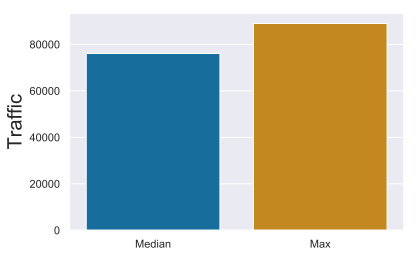

In [91]:
median_max_plot = sns.barplot(x="STATUS", y='Traffic', data=median_vs_max_df, palette=("colorblind"),label = None)
median_max_plot.set_xlabel("")
median_max_plot.set_ylabel('Traffic',size = 20)
%config InlineBackend.figure_format = 'svg'

In [ ]:
#compared it to the median number to make sure it is not a randomly, inaacurate high number
#it is about 12,000 people more on that day
#It turns out to be an event nearby


In [ ]:
#My hypothesis is that if there is an event closeby, we will get a high number in a short period of time. 
#To test this hypothesis, we need to compare the high traffic with event lists.
#I noticed that the top 20 high numbers are in either 34 penn station or herald square, which are within 2 
#blocks away from madison square garden. So the initial quick check is to compare the event list of MSG with 
#the top 20 dates
#There is some hits: for example: on 2017-12-20, there is Billy Joel's concert; on 2017-12-8, there is a Jingle Ball 
#concert
#Next step is to analyze what event we should target. 

In [ ]:
import seaborn as sns
from pylab import savefig
sns.set(style="whitegrid")
Population_chart = sns.barplot(x="STATION", y="POPULATION", data=zipCodeData, palette=("colorblind"),label = None)
Population_chart.set_xticklabels(zipCodeData.STATION,rotation= 90)
Population_chart.set_xlabel("")
Population_chart.set_ylabel('POPULATION',size = 20)
Population_chart2 =Population_chart.twinx()
fig = zipCodeData.plot(x="STATION", y="NETTRAFFIC", ax=Population_chart2, legend=True, color="black",grid=False, linewidth = 5)

#%config InlineBackend.figure_format = 'jpeg'
figure = fig.get_figure()    
figure.savefig('polulation_station.jpeg', dpi= 3000, bbox_inches='tight')

#sns.set_context("poster")
#sns.set_context("poster", font_scale= 1)
